## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

### Task 1

In [39]:
# data file
file_name = "./data_000637.txt"

# load data into a dataframe
df_tot = pd.read_csv(file_name)

df_tot

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


### Task 2

In [40]:
# let's assume that every BX value is present in the dataset (at least, let's assume its maximum is)
# then we simply get the maximum BX value and add 1 to it (as it starts from 0)
x = df_tot["BX_COUNTER"].max() + 1

print(f"One ORBIT_CNT corresponds to {x} BX_COUNTERs")

One ORBIT_CNT corresponds to 3564 BX_COUNTERs


### Task 3 & 4

In [37]:
# let's convert the "(h:m:s)" format into a single time value in nanoseconds
df_tot["TIME"] = df_tot["ORBIT_CNT"]*x*25 + df_tot["BX_COUNTER"]*25 + df_tot["TDC_MEAS"]*25/30
df_tot.sort_values(by="TIME", ascending=True, inplace=True) # make sure data is ordered

# to find out how much the data taking lasted we simply subtract the initial time stamp from the last one
run_time = df_tot["TIME"].iloc[-1] - df_tot["TIME"].iloc[0]

print(f"Data have been collected for {run_time*1e-9} seconds")

Data have been collected for 0.9804162533125 seconds


Data collection time seems a bit too low......

### Task 5

In [50]:
# replace the "HEAD" column with either 0 or 1 chosen at random
df_tot["HEAD"] = np.random.randint(low=0, high=2, size=len(df_tot))

# check the unique values in the "HEAD" columns: they should be 0 and 1
df_tot["HEAD"].unique()

array([1, 0])

### Task 6

In [53]:
# select only the rows with "HEAD" equal to 1
df_head_1 = df_tot[df_tot["HEAD"]==1]

# check the unique values in the "HEAD" columns: it should be just 1
df_head_1["HEAD"].unique()

array([1])

### Task 7

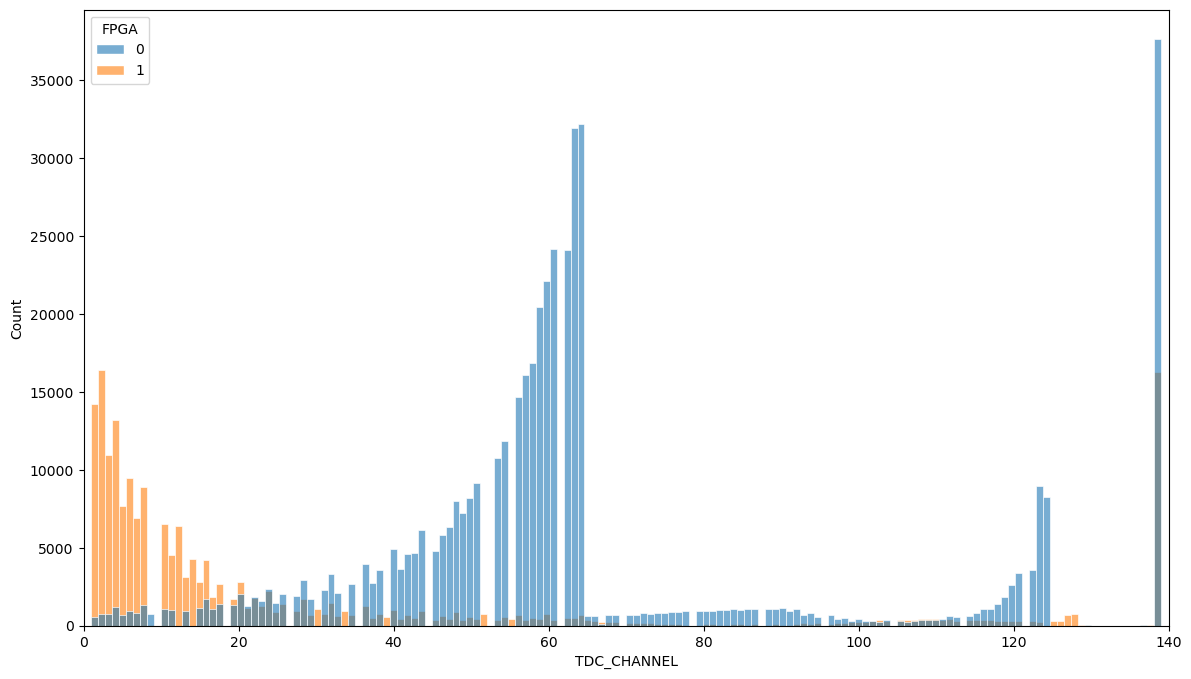

In [104]:
fig, ax = plt.subplots(figsize=(14, 8))

sns.histplot(
    data=df_head_1, 
    x="TDC_CHANNEL", 
    hue="FPGA",
    stat="count", 
    element="bars", 
    fill=True, 
    color=["#009cff", "#FF6300"], 
    edgecolor="white", 
    alpha=0.6,
    ax=ax
)

ax.set_xlim(df_head_1["TDC_CHANNEL"].min()-1, df_head_1["TDC_CHANNEL"].max()+1)
plt.show()

Data is quite pathological.... should not look like this! I would've expected an almost flat distribution!!

### Task 8

In [121]:
# group by FPGA and TDC_CHANNEL
df_grouped = df_tot.groupby(["FPGA", "TDC_CHANNEL"], as_index=False).count()
# select relevant columns
df_grouped = df_grouped.loc[:, ["FPGA", "TDC_CHANNEL", "HEAD"]].rename(columns={"HEAD": "COUNTS"})
# sort the dataframe based on the TDC_CHANNEL counts
df_grouped.sort_values(["COUNTS"], ascending=False, inplace=True, ignore_index=True)

print("Overall top 3:\n")
print(df_grouped.iloc[:3])
print("\n"+"*"*30+"\n")
print("FPGA==0 top 3:\n")
print(df_grouped[df_grouped["FPGA"]==0].iloc[:3])
print("\n"+"*"*30+"\n")
print("FPGA==1 top 3:\n")
print(df_grouped[df_grouped["FPGA"]==1].iloc[:3])

Overall top 3:

   FPGA  TDC_CHANNEL  COUNTS
0     0          139   75617
1     0           64   64581
2     0           63   63724

******************************

FPGA==0 top 3:

   FPGA  TDC_CHANNEL  COUNTS
0     0          139   75617
1     0           64   64581
2     0           63   63724

******************************

FPGA==1 top 3:

    FPGA  TDC_CHANNEL  COUNTS
8      1            2   32669
9      1          139   32442
12     1            1   28438


### Task 9

In [123]:
# count the number of unique ORBIT_CNT values
n_orbits = df_tot["ORBIT_CNT"].nunique()
# count the number of unique ORBIT_CNT values (considering only those in which a scintillator signal is present)
n_orbits_tdc_139 = df_tot[(df_tot["TDC_CHANNEL"]==139)]["ORBIT_CNT"].nunique()

print(f"Number of unique orbits: {n_orbits}")
print(f"Number of unique orbits with at least one measurement from TDC_CHANNEL==139: {n_orbits_tdc_139}")

Number of unique orbits: 11001
Number of unique orbits with at least one measurement from TDC_CHANNEL==139: 10976
